In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from IPython.display import Image
import cv2 as cv
import os
import pydot
from tensorflow.keras.layers import Dropout

2024-08-16 04:25:47.869838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 04:25:47.869955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 04:25:48.011872: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


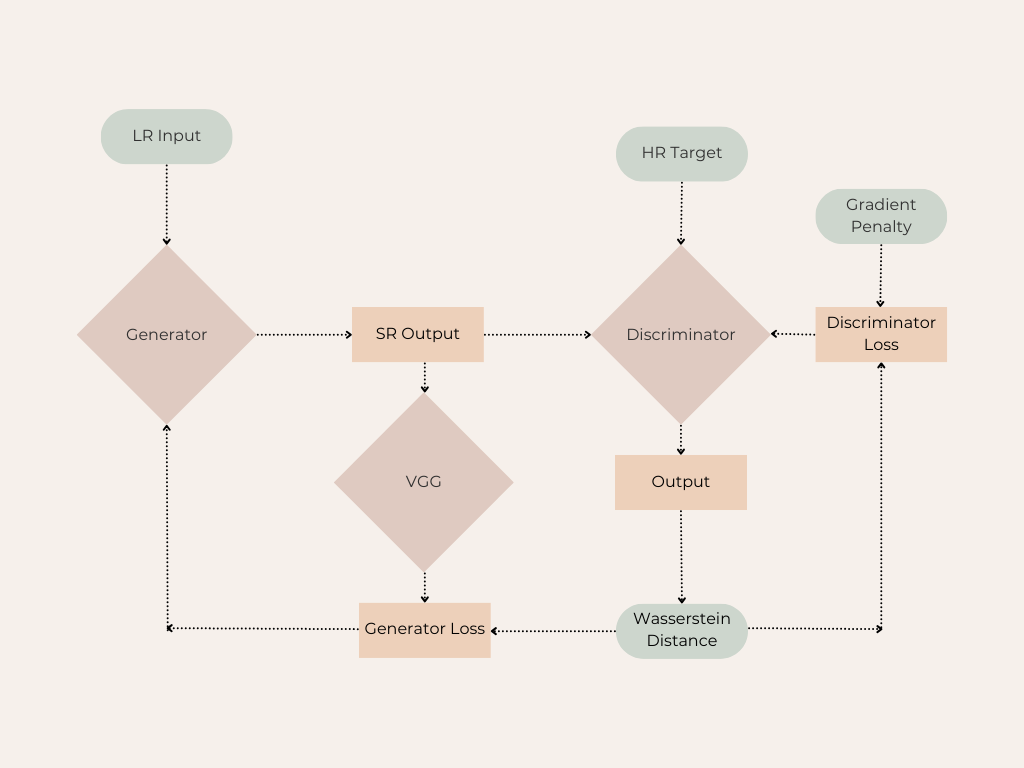

In [2]:
Image(filename='/kaggle/input/imd-architecture/Architecture_IMD.png')

In [3]:
import pickle
SR_file_path = '/kaggle/input/imd-final-dataset/SR_Data_final/SR_Data_final.pkl'
LR_file_path = '/kaggle/input/imd-final-dataset/LR_Data_final/LR_Data_final.pkl'
with open(SR_file_path, 'rb') as file:
    SR_data = pickle.load(file)
with open(LR_file_path, 'rb') as file:
    LR_data = pickle.load(file)

In [4]:
import pickle
SR_pic_file_path = '/kaggle/input/imd-lr-sr/data/data.pkl'
LR_pic_file_path = '/kaggle/input/imd-lr-sr/LR_data/LR_data.pkl'
with open(SR_pic_file_path, 'rb') as file:
    SR_pic_data = pickle.load(file)
with open(LR_pic_file_path, 'rb') as file:
    LR_pic_data = pickle.load(file)

In [5]:
for key in SR_data:
    rainfall_array_final = [] 
    for j in range(SR_data[key].shape[0]):
        k = SR_data[key][j, 1:]
        nan_column = np.full((k.shape[0], 1), -1)
        modified_row = np.hstack((k, nan_column))
        rainfall_array_final.append(modified_row)
    rainfall_array_final = np.array(rainfall_array_final)
    SR_data[key] = rainfall_array_final
for key in SR_pic_data:
    rainfall_array_final = [] 
    for j in range(SR_pic_data[key].shape[0]):
        k = SR_pic_data[key][j, 1:]
        nan_column = np.full((k.shape[0], 1), -1)
        modified_row = np.hstack((k, nan_column))
        rainfall_array_final.append(modified_row)
    rainfall_array_final = np.array(rainfall_array_final)
    SR_pic_data[key] = rainfall_array_final


In [6]:
print(SR_data[1901][0].shape)
print(SR_pic_data[1901][0].shape)

(128, 136)
(128, 136)


128 136


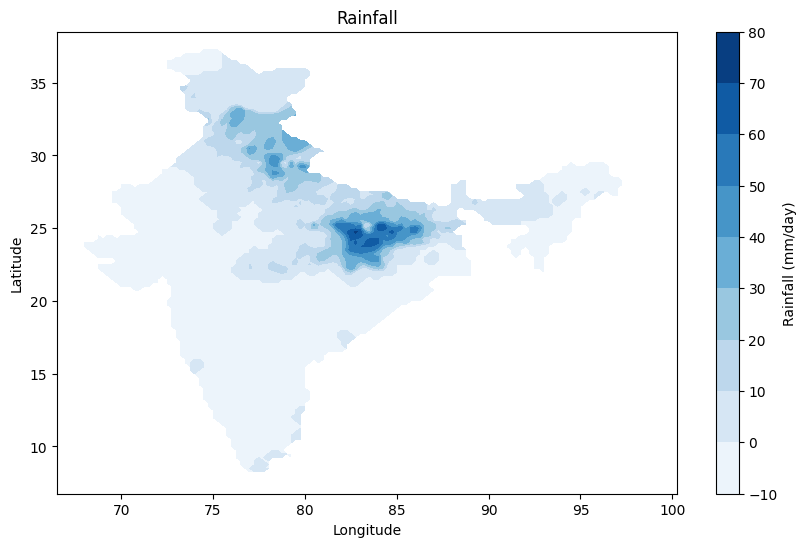

In [7]:
SR_rainfall = SR_pic_data[1901][0]
lat25 = np.load('/kaggle/input/coordinates-imd/0.25lat.npy')
lon25 = np.load('/kaggle/input/coordinates-imd/0.25lon.npy')
print(len(lat25),len(lon25))
plt.figure(figsize=(10, 6))
X_SR, Y_SR = np.meshgrid(lon25, lat25)
plt.contourf(X_SR, Y_SR, SR_rainfall, cmap='Blues')
plt.colorbar(label='Rainfall (mm/day)')
plt.title(f'Rainfall')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [8]:
for key in LR_data:
    final_rainfall_array = []
    for j in range(LR_data[key].shape[0]):
        k = LR_data[key][j][1:][:]
        k = np.delete(k,0,1)
        final_rainfall_array.append(k)
    LR_data[key] = final_rainfall_array
for key in LR_pic_data:
    final_rainfall_array = []
    for j in range(LR_pic_data[key].shape[0]):
        k = LR_pic_data[key][j][1:][:]
        k = np.delete(k, 0, 1)
        final_rainfall_array.append(k)
    LR_pic_data[key] = final_rainfall_array

In [9]:
print(LR_data[1901][0].shape)

(32, 34)


32 34
(32, 34)


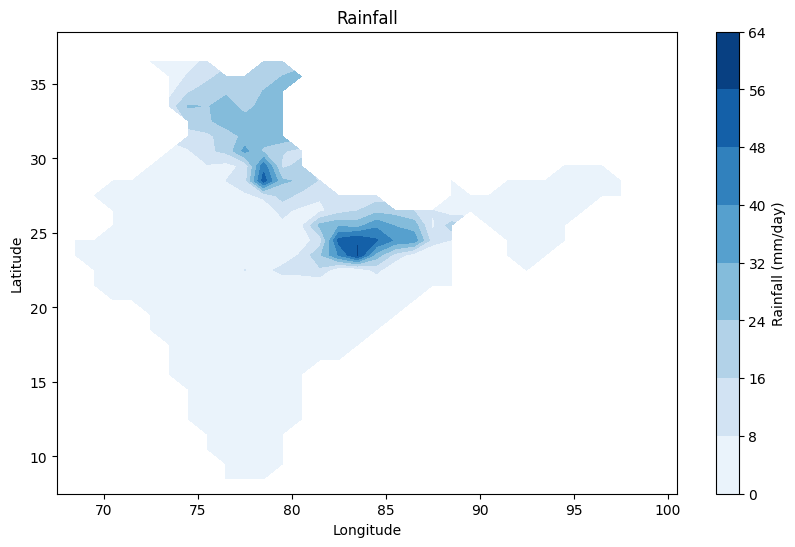

In [10]:
LR_rainfall = LR_pic_data[1901][0]
lat1 = np.load('/kaggle/input/coordinates-imd/1lat.npy')
lon1 = np.load('/kaggle/input/coordinates-imd/1lon.npy')
print(len(lat1),len(lon1))
print(LR_rainfall.shape)
plt.figure(figsize=(10, 6))
X_LR, Y_LR = np.meshgrid(lon1, lat1)
plt.contourf(X_LR, Y_LR, LR_rainfall, cmap='Blues')
plt.colorbar(label='Rainfall (mm/day)')
plt.title(f'Rainfall')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Cleaning Data

In [11]:
del SR_data[2002]
del SR_data[2003]
del SR_data[2023]
del LR_data[2002]
del LR_data[2003]
del LR_data[2023]

# Generator

In [12]:
class DepthToSpaceLayer(tf.keras.layers.Layer):
    def __init__(self, block_size, **kwargs):
        super(DepthToSpaceLayer, self).__init__(**kwargs)
        self.block_size = block_size

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.block_size)
def residual_block_gen(ch=64, k_s=3, st=1):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(ch, k_s, strides=(st, st), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D(ch, k_s, strides=(st, st), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
    ])
    return model
def Upsample_block(x, ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch, k_s, strides=(st, st), padding='same')(x)
    x = DepthToSpaceLayer(block_size=2)(x)  
    x = tf.keras.layers.LeakyReLU()(x)
    return x
input_lr = tf.keras.layers.Input(shape=(None, None, 1))
input_conv = tf.keras.layers.Conv2D(64, 9, padding='same')(input_lr)
input_conv = tf.keras.layers.LeakyReLU()(input_conv)
Generator = input_conv
for _ in range(8):
    res_output = residual_block_gen()(Generator)
    Generator = tf.keras.layers.Add()([Generator, res_output])
Generator = tf.keras.layers.Conv2D(64, 9, padding='same')(Generator)
Generator = tf.keras.layers.BatchNormalization()(Generator)

Generator = tf.keras.layers.Add()([Generator, input_conv])

Generator = Upsample_block(Generator)  
Generator = Upsample_block(Generator) 
output_sr = tf.keras.layers.Conv2D(1, 9, activation='linear', padding='same')(Generator)

Generator = tf.keras.models.Model(input_lr, output_sr)


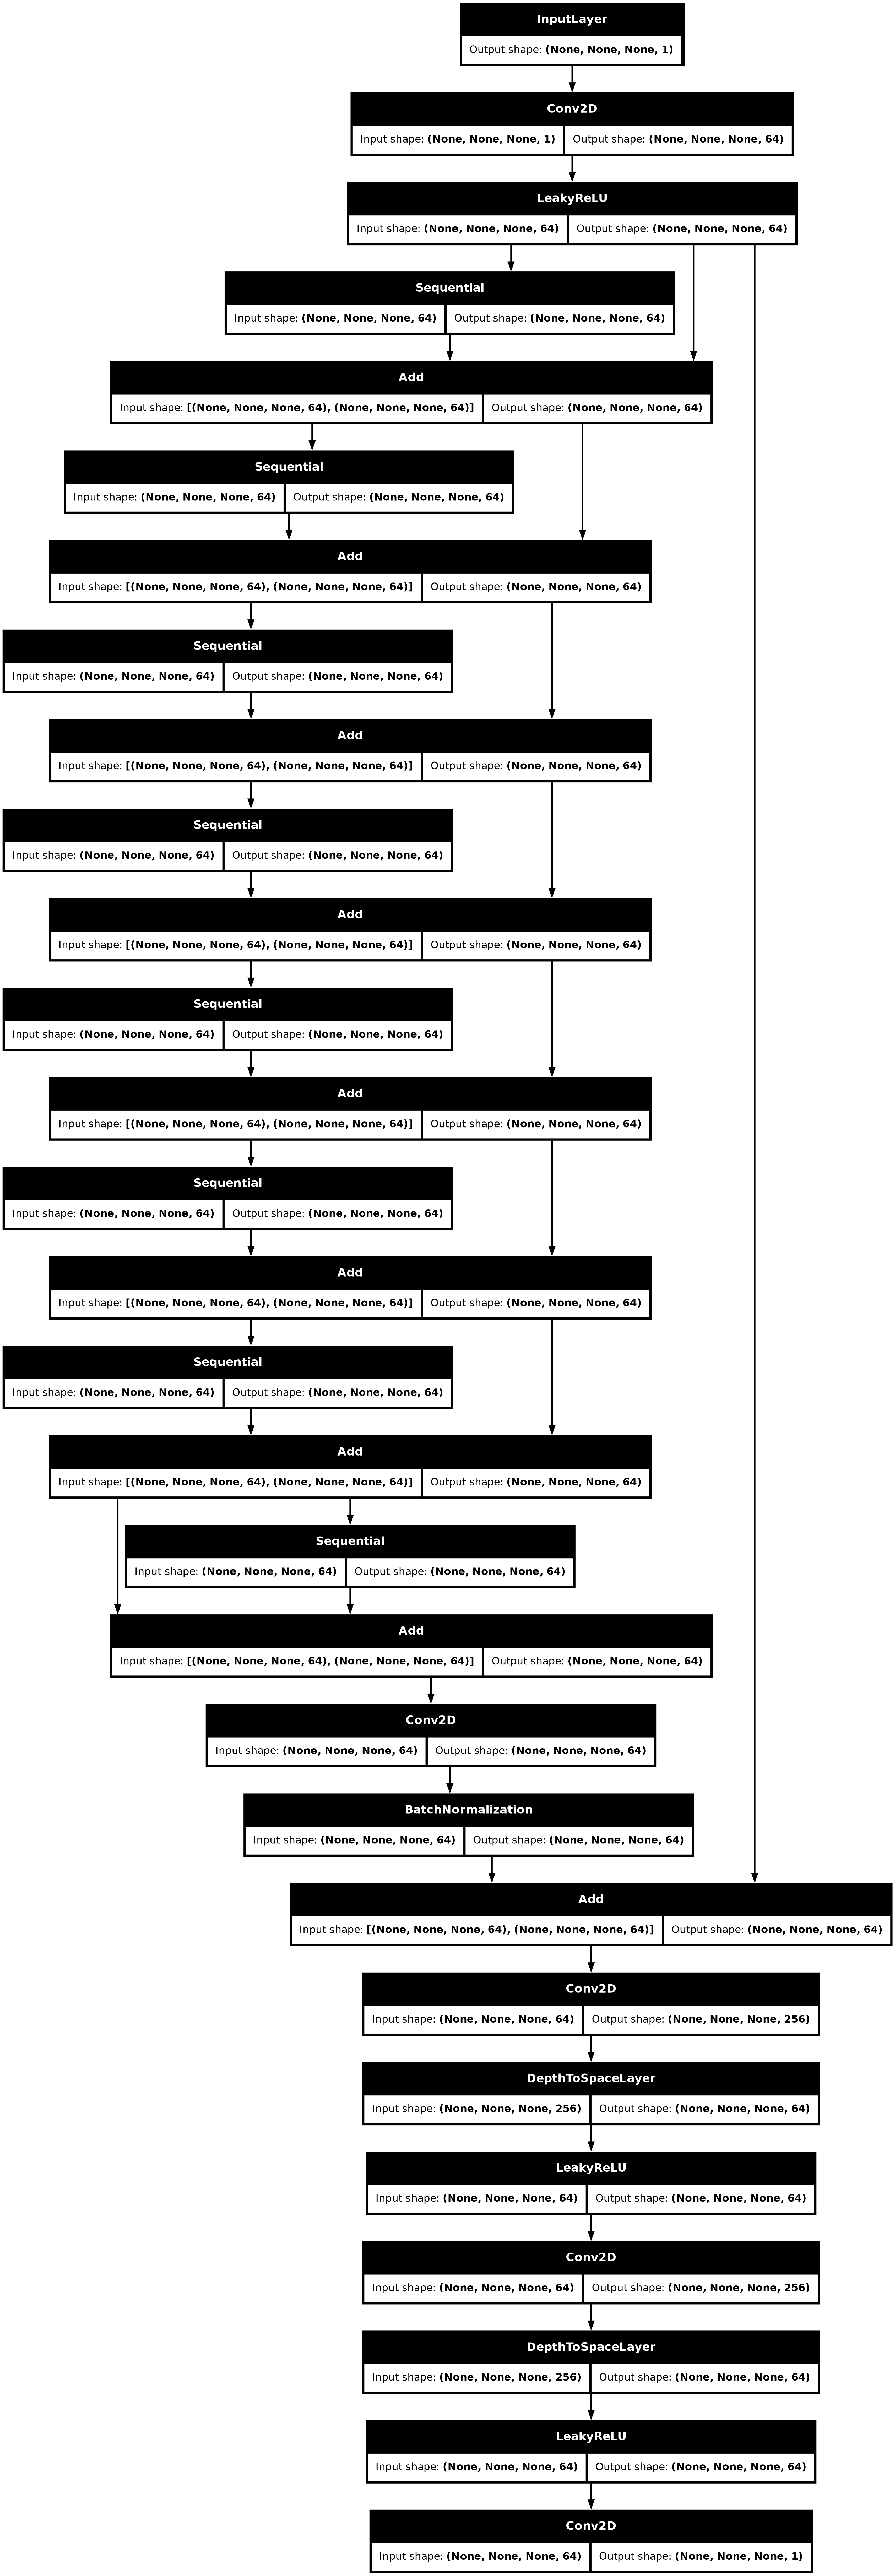

In [13]:
tf.keras.utils.plot_model(Generator, show_shapes=True)

In [14]:
Generator.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 1)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │      5,248 │ input_layer[0][0] │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, None,      │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None,      │     74,368 │ leaky_re_lu[0][0] │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None,      │          0 │ leaky_re_lu[0][0… │
│                     │ None, 64)         │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, None,      │     74,368 │ add[0][0]         │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None,      │          0 │ add[0][0],        │
│                     │ None, 64)         │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, None,      │     74,368 │ add_1[0][0]       │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None,      │          0 │ add_1[0][0],      │
│                     │ None, 64)         │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, None,      │     74,368 │ add_2[0][0]       │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, None,      │          0 │ add_2[0][0],      │
│                     │ None, 64)         │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, None,      │     74,368 │ add_3[0][0]       │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, None,      │          0 │ add_3[0][0],      │
│                     │ None, 64)         │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, None,      │     74,368 │ add_4[0][0]       │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, None,      │          0 │ add_4[0][0],      │
│                     │ None, 64)         │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, None,      │     74,368 │ add_5[0][0]       │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, None,      │          0 │ add_5[0][0],    

 Total params: 1,232,897 (4.70 MB)

 Trainable params: 1,230,721 (4.69 MB)

 Non-trainable params: 2,176 (8.50 KB)

# Discriminator (Critic)

In [15]:
def residual_block_disc(ch=64, k_s=3, st=1):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(ch, k_s, strides=(st, st), padding='same',
                               kernel_initializer=tf.keras.initializers.HeNormal()),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        # Optional: Move BatchNormalization after activation or remove
        # tf.keras.layers.BatchNormalization(),
    ])
    return model

input_lr = tf.keras.layers.Input(shape=(128, 136, 1))
input_conv = tf.keras.layers.Conv2D(64, 3, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(input_lr)
input_conv = tf.keras.layers.LeakyReLU(alpha=0.2)(input_conv)

channel_nums = [64, 128, 128, 256, 256, 512, 512]
stride_sizes = [2, 1, 2, 1, 2, 1, 2]

disc = input_conv
for x in range(7):
    disc = residual_block_disc(ch=channel_nums[x], st=stride_sizes[x])(disc)

disc = tf.keras.layers.Flatten()(disc)
disc = tf.keras.layers.Dense(1024, kernel_initializer=tf.keras.initializers.HeNormal())(disc)
disc = tf.keras.layers.LeakyReLU(alpha=0.2)(disc)
disc_output = tf.keras.layers.Dense(1)(disc) 
discriminator = tf.keras.models.Model(input_lr, disc_output)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


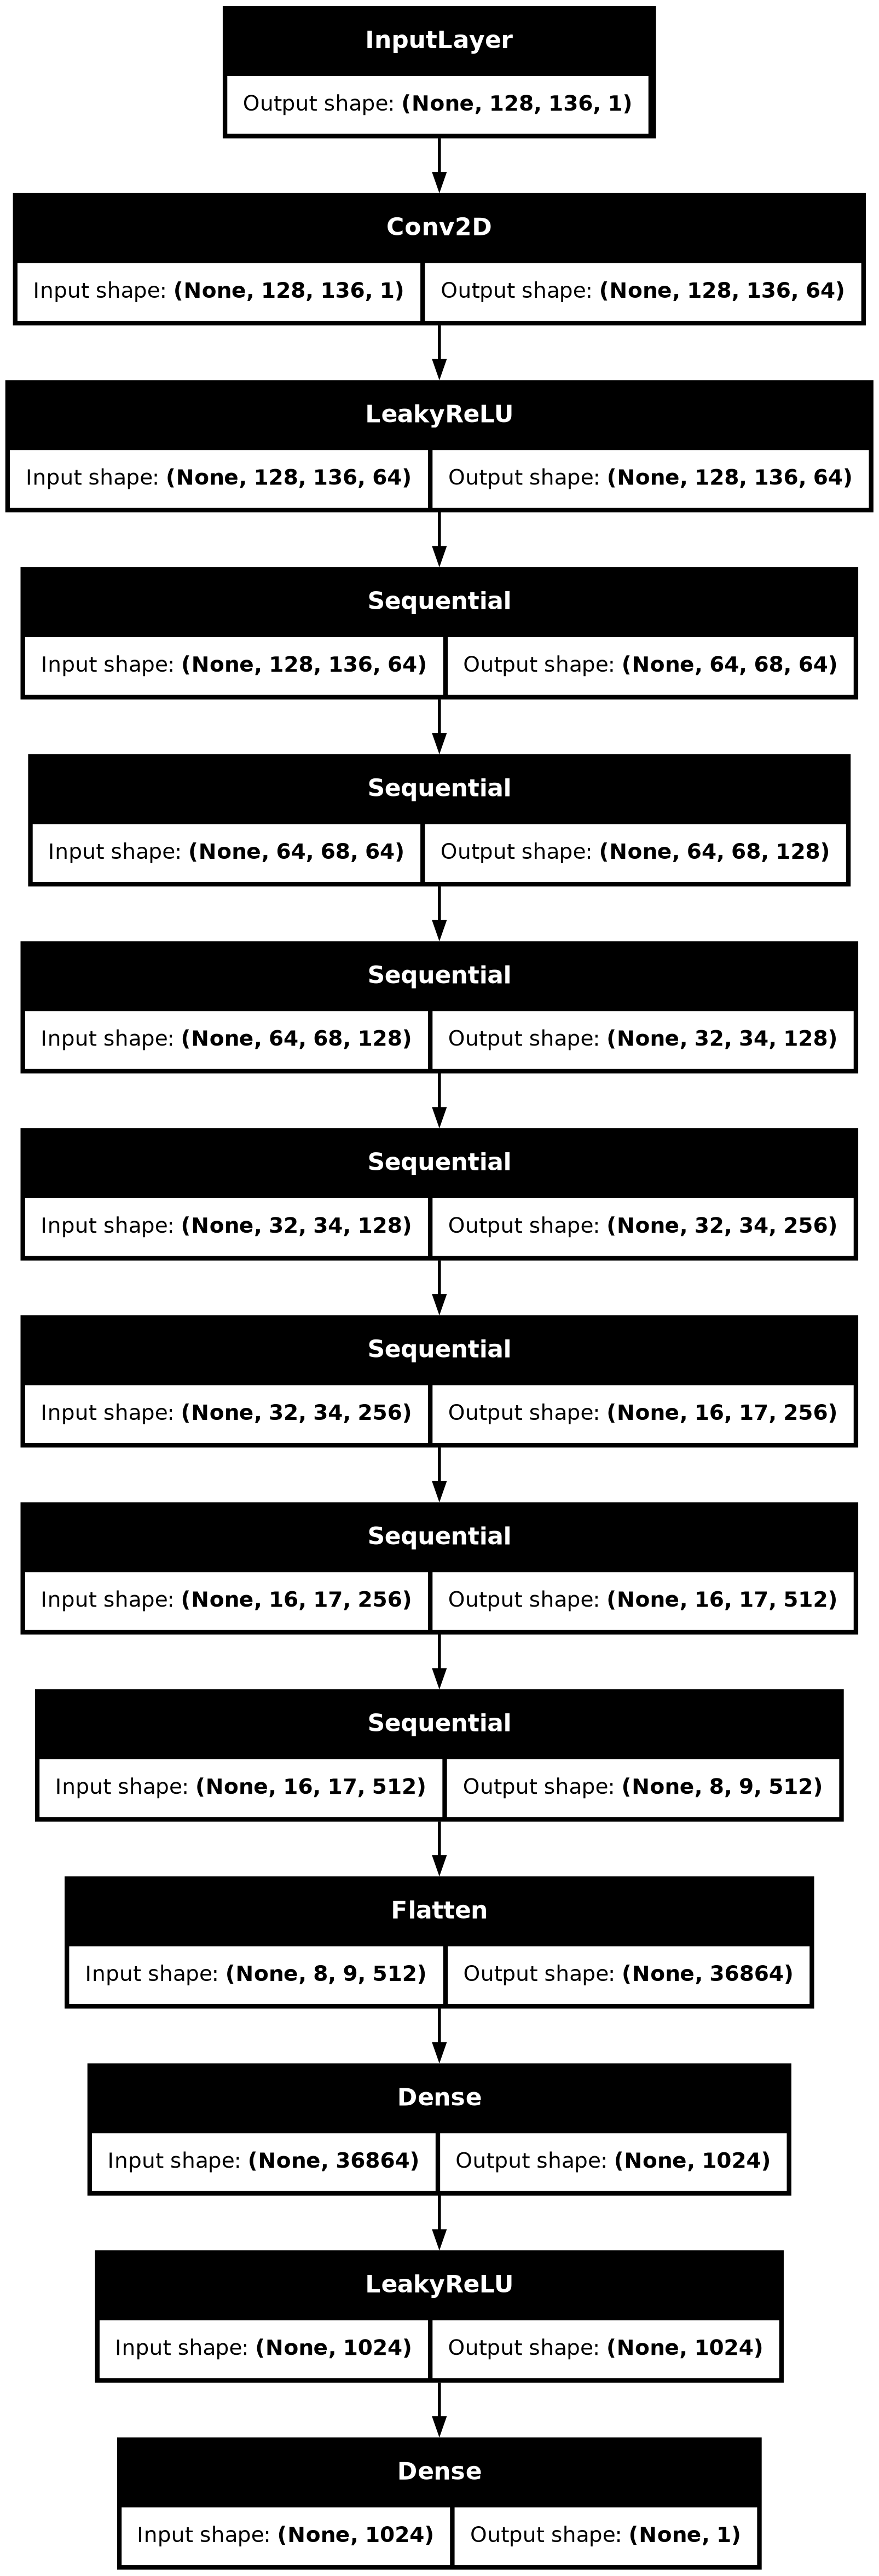

In [16]:
tf.keras.utils.plot_model(discriminator,show_shapes=True)

In [17]:
discriminator.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 128, 136, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 128, 136, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 128, 136, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 64, 68, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 64, 68, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (None, 32, 34, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_11 (Sequential)      │ (None, 32, 34, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_12 (Sequential)      │ (None, 16, 17, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_13 (Sequential)      │ (None, 16, 17, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_14 (Sequential)      │ (None, 8, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    37,749,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,435,009 (161.88 MB)

 Trainable params: 42,435,009 (161.88 MB)

 Non-trainable params: 0 (0.00 B)

# Feature Extractor


In [18]:
from keras.models import load_model
model = load_model('/kaggle/input/rainfall_feature_extractor/tensorflow2/default/1/final.h5')
layer_names = ['vgg16', 'dense'] 

In [19]:
layer_outputs = [model.get_layer(name).output for name in layer_names]
feature_extractor_1 = Model(inputs=model.input, outputs=model.get_layer('flatten').output)
# feature_extractor_2 = Model(inputs=model.input, outputs=model.get_layer('dense').output)
feature_extractor_1.summary()
# feature_extractor_2.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 136, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 136, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 136, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 136, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 136, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 136, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 136, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 136, 3)    │         1,731 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 136, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128, 136, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,754,511 (56.28 MB)

 Trainable params: 39,561 (154.54 KB)

 Non-trainable params: 14,714,950 (56.13 MB)

In [20]:
def gradient_penalty(discriminator, real_images, fake_images):
    batch_size = tf.shape(real_images)[0]
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    interpolated_images = alpha * real_images + (1 - alpha) * fake_images

    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        predictions = discriminator(interpolated_images)

    gradients = tape.gradient(predictions, interpolated_images)
    gradients_sqr_sum = tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3])
    gradient_l2_norm = tf.sqrt(gradients_sqr_sum + 1e-8)
    gradient_penalty = tf.reduce_mean((gradient_l2_norm - 1.0) ** 2)

    return gradient_penalty

In [21]:
def discriminator_loss(real_output, fake_output, gp, lambda_gp=10):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) + lambda_gp * gp


In [22]:
def generator_loss(fake_output, real_images, fake_images, feature_extractor_1):
    adv_loss = -tf.reduce_mean(fake_output)
    feature_loss = 0
    real_feature_1 = feature_extractor_1(real_images)
    fake_feature_1 = feature_extractor_1(fake_images)
#     real_feature_2 = feature_extractor_2(real_images)
#     fake_feature_2 = feature_extractor_2(fake_images)
    for real, fake in zip(real_feature_1, fake_feature_1):
        feature_loss += tf.reduce_mean(tf.abs(real - fake))
#     for real, fake in zip(real_feature_2, fake_feature_2):
#         feature_loss += tf.reduce_mean(tf.abs(real - fake))
#     feature_loss/=2
    total_loss =  adv_loss + feature_loss
    return total_loss

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.0, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.0, beta_2=0.9)

def train_step(SR_images, LR_images, batch_size):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = Generator(LR_images, training=True)
        real_output = discriminator(SR_images, training=True)
        fake_output = discriminator(fake_images, training=True)
        gp = gradient_penalty(discriminator, SR_images, fake_images)
        gen_loss = generator_loss(fake_output, SR_images, fake_images, feature_extractor_1)
        disc_loss = discriminator_loss(real_output, fake_output, gp)
    
    # Compute gradients for the generator, discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, Generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Apply gradients to update the weights
    generator_optimizer.apply_gradients(zip(gradients_of_generator, Generator.trainable_variables ))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

# Training loop
def train(SR_data, LR_data, epochs, batch_size):
    for epoch in range(epochs):
        for year in range(1901, 2024):
            if year in [2002, 2003, 2023]:
                continue
            days_in_year = len(LR_data[year])
            indices = np.arange(days_in_year)
            np.random.shuffle(indices)
            batches = [indices[i:i+batch_size] for i in range(0, days_in_year, batch_size)]

            for batch_indices in batches:
                lr = np.array([LR_data[year][j] for j in batch_indices]).reshape((len(batch_indices), 32, 34, 1))
                sr = np.array([SR_data[year][j] for j in batch_indices]).reshape((len(batch_indices), 128, 136, 1))
                gen_loss, disc_loss = train_step(sr, lr, len(batch_indices))
            
            if year % 10 == 0:
                print(f'Epoch {epoch+1}, Year {year}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}')
                
                # Visualization code (unchanged)
                sr_pic = np.array(SR_pic_data[2000][0])
                lr_pic = np.array(LR_data[2000][:32]).reshape((32, 32, 34, 1))
                generated = np.array(Generator(lr_pic))
                plt.figure(figsize=(14, 6))
                plt.subplot(1, 2, 1)
                X_SR, Y_SR = np.meshgrid(lon25, lat25)
                plt.contourf(X_SR, Y_SR, generated[0].reshape(128, 136), cmap='Blues')
                plt.colorbar(label='Rainfall (mm/day)')
                plt.title('Generated Rainfall data')
                plt.xlabel('Longitude')
                plt.ylabel('Latitude')
                plt.subplot(1, 2, 2)
                plt.contourf(X_SR, Y_SR, sr_pic, cmap='Blues')
                plt.colorbar(label='Rainfall (mm/day)')
                plt.title('Actual Rainfall data')
                plt.xlabel('Longitude')
                plt.ylabel('Latitude')
                plt.show()
        Generator.save(f'generator_epoch_{epoch+1}.h5')
        discriminator.save(f'discriminator_epoch_{epoch+1}.h5')
        print(f'Models saved after epoch {epoch+1}')

Epoch 1, Year 1910, Generator Loss: -582.8423461914062, Discriminator Loss: -3229.658203125


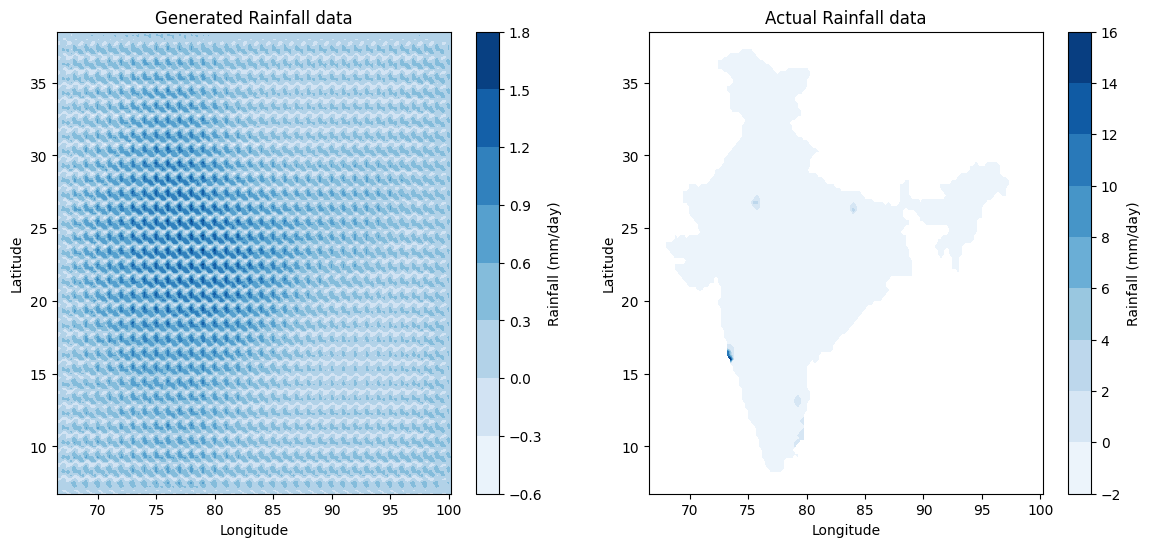

Epoch 1, Year 1920, Generator Loss: -457.5284729003906, Discriminator Loss: -916.6827392578125


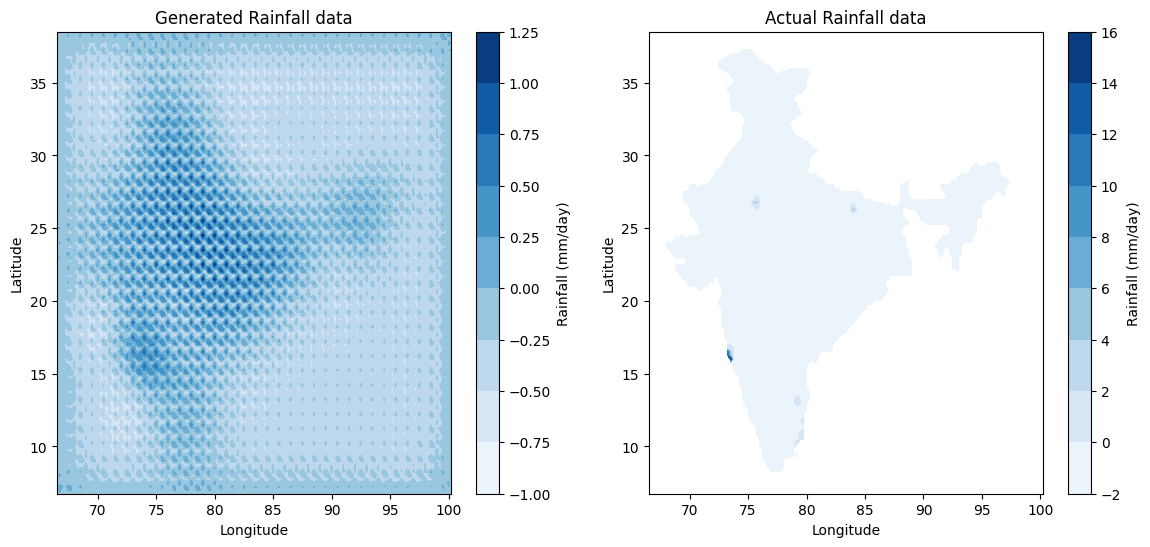

Epoch 1, Year 1930, Generator Loss: -735.1965942382812, Discriminator Loss: -961.158935546875


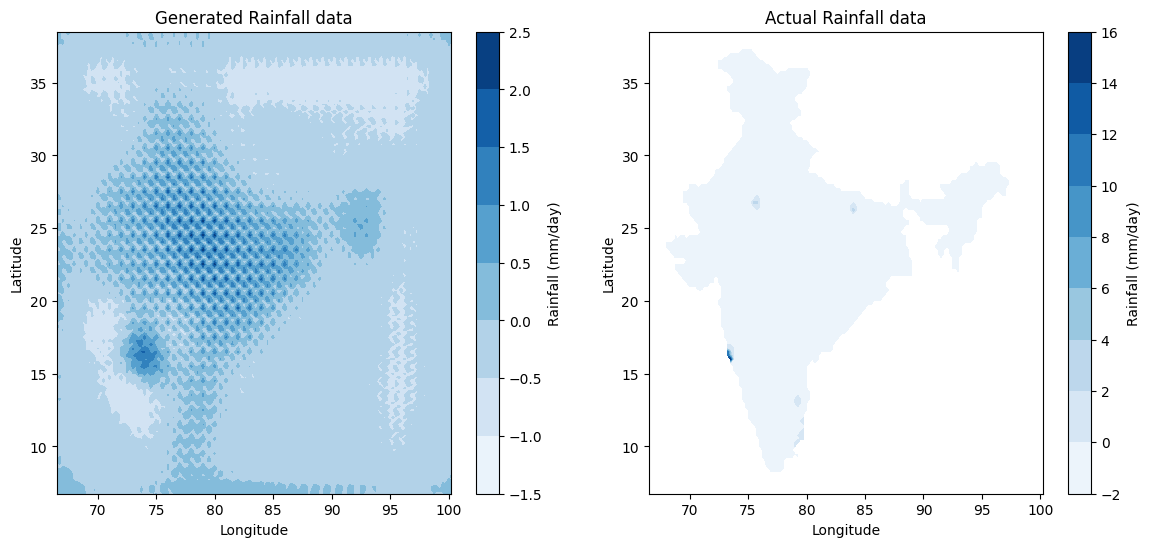

Epoch 1, Year 1940, Generator Loss: -219.3531036376953, Discriminator Loss: -2076.54345703125


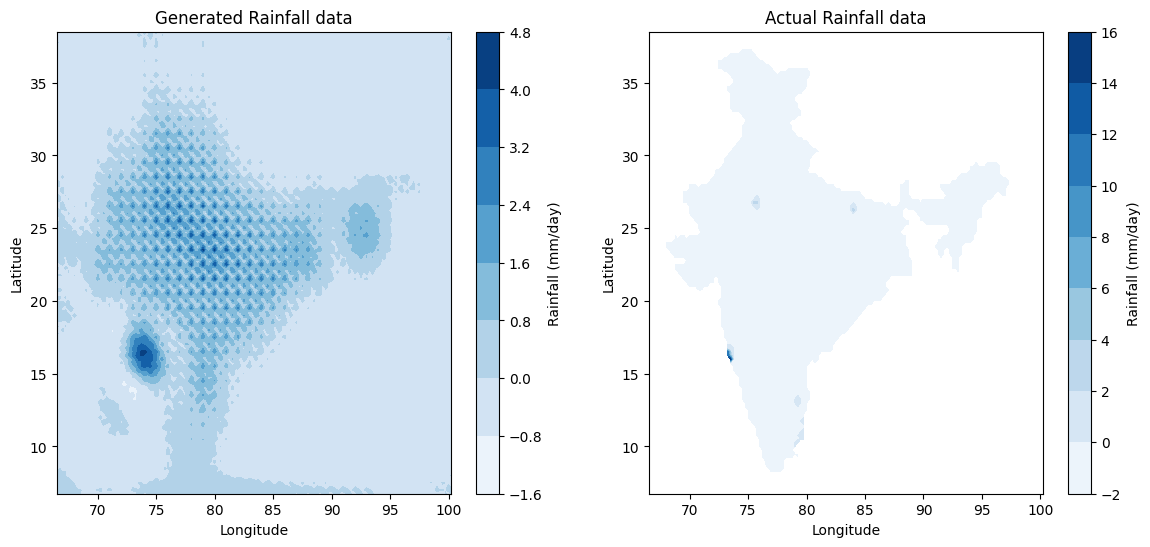

Epoch 1, Year 1950, Generator Loss: -296.3161926269531, Discriminator Loss: -1790.948974609375


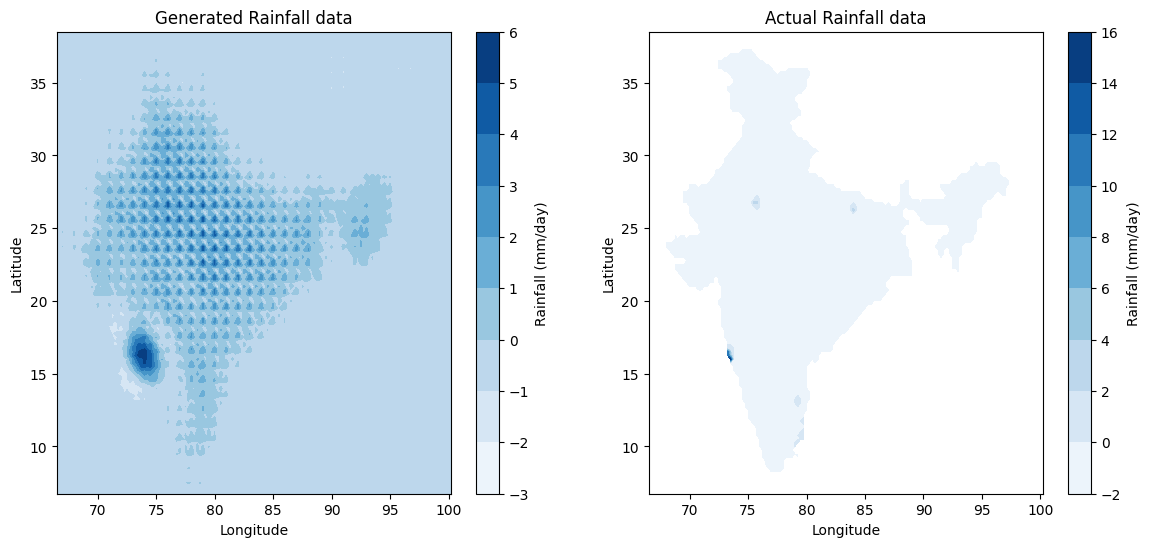

Epoch 1, Year 1960, Generator Loss: 248.90768432617188, Discriminator Loss: -1582.4609375


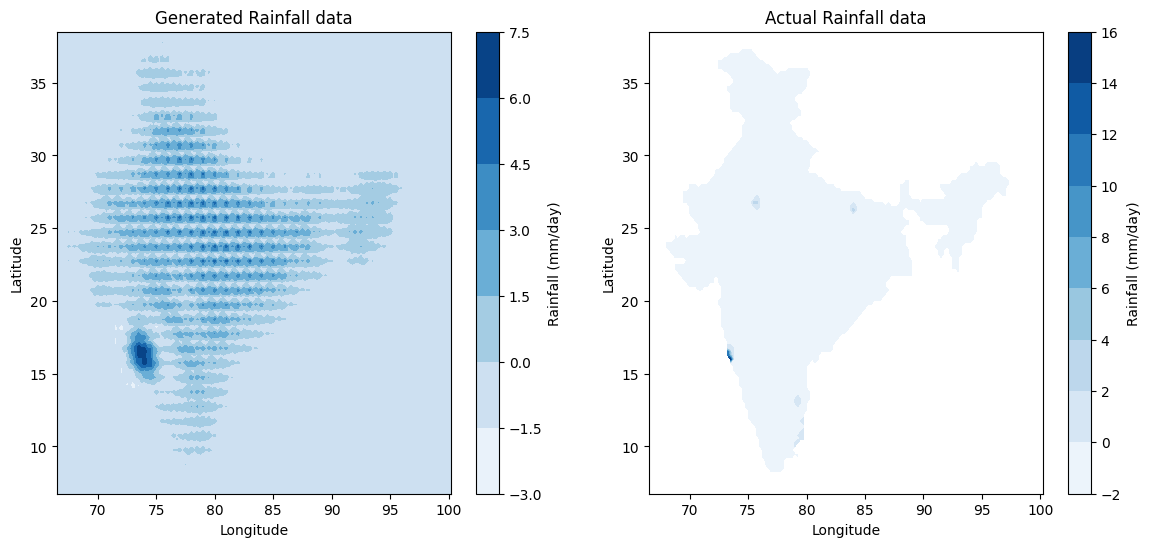

KeyboardInterrupt: 

In [24]:
train(SR_data,LR_data, epochs=5, batch_size=32)

In [25]:
sr = np.array(SR_data[2000][0]).reshape((1, 128, 136, 1))
sr = sr.astype(np.float16)
generated = np.array(Generator(sr))
print(generated[0].shape)

(512, 544, 1)


In [26]:
lon = np.arange(len(lon25)*4)
lat = np.arange(len(lat25)*4)

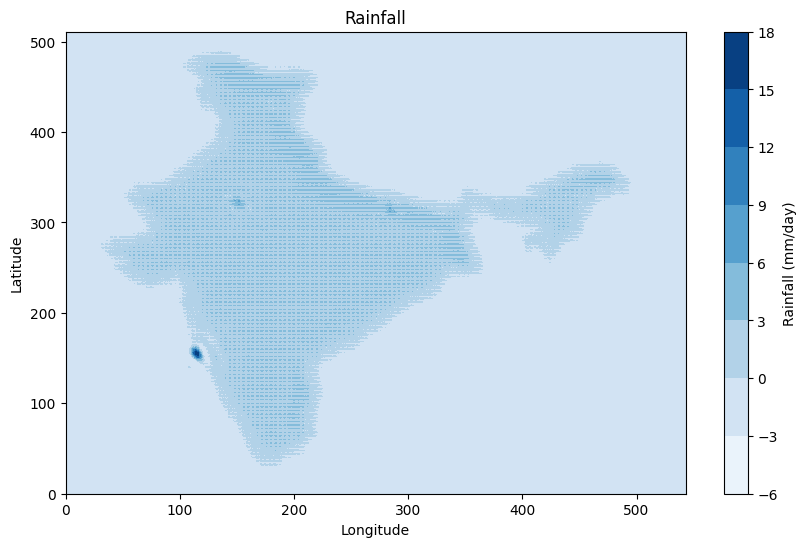

In [27]:
plt.figure(figsize=(10, 6))
X_SR, Y_SR = np.meshgrid(lon, lat)
plt.contourf(X_SR, Y_SR, generated[0].reshape(512, 544), cmap='Blues')
plt.colorbar(label='Rainfall (mm/day)')
plt.title(f'Rainfall')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
# plt.contourf(X_SR, Y_SR, generated[0].reshape(), cmap='Blues')
# plt.colorbar(label='Rainfall (mm/day)')
# plt.title('Actual Rainfall data')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()

In [ ]:
Generator.save(f'generator_epoch_5.h5')
discriminator.save(f'discriminator_epoch_5.h5')